In [1]:
import numpy as np 

from collections import Counter

import matplotlib.pyplot as plt 
from sklearn.preprocessing import normalize

import scipy.special

from dredFISH.Analysis.TissueGraph import *
from dredFISH.Analysis.Taxonomy import *


from MERFISH_Objects.FISHData import *



In [2]:
base_path = '/bigstore/Images2021/gaby/dredFISH/DPNMF_PolyA_2021Nov19/'
dataset = 'DPNMF_PolyA_2021Nov19'
fishdata = FISHData(os.path.join(base_path,'fishdata'))
data = fishdata.load_data('h5ad',dataset=dataset)
data.obs_names_make_unique()

data.X = data.layers['total_vectors']
data = data[np.isnan(data.X.max(1))==False]

data.X = data.X/data.obs['total_signal'][:,None]
data.X = data.X - np.array([np.percentile(data.X[:,i],25) for i in range(data.X.shape[1])])
data.X = data.X / np.array([np.percentile(data.X[:,i],75) for i in range(data.X.shape[1])])
data.X = normalize(data.X)

XY = np.asarray([data.obs['stage_y'], data.obs['stage_x']])
XY = np.transpose(XY)
data.obsm['stage'] = XY

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/tmp/ipykernel_452391/676460092.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  data.X = data.X/data.obs['total_signal'][:,None]


In [3]:
TG = TissueGraph()
TG.BuildSpatialGraph(XY)

redo=True
if redo:
    celltypes = TG.TX.RecursiveLeidenWithTissueGraphCondEntropy(data.X,TG,metric = 'cosine',single_level=True)
    TG.Type = celltypes
else: 
    df = pd.read_csv('leaflabels_dev.csv')
    lbl = np.array(df,dtype='str').T
    celltypes = lbl[0]
    TG.Type = celltypes
    
TG.TX.BuildTree()

Build similarity graph 
calculation took: 61.66
Calling initial optimization
 
 Func-count     x          f(x)          Procedure
    1        11.5208     -7.55665        initial
    2        18.5792     -7.31716        golden
    3        7.15843     -7.70686        golden
    4        4.46235     -7.54883        golden
    5        8.03358     -7.62313        parabolic
    6        6.12862     -7.60566        golden
    7        7.12613     -7.71507        parabolic
    8        6.74511     -7.68286        golden
    9        6.98718     -7.77227        parabolic
   10        6.89472     -7.67674        golden
   11        7.04026     -7.71984        golden
   12        6.95187     -7.68278        golden
   13        7.00745     -7.70591        golden
   14        6.97369     -7.72399        golden
   15        6.99493     -7.69403        golden
   16        6.98203     -7.74311        golden
   17        6.99052     -7.71697        golden

Optimization terminated successfully;
The r

In [4]:
ZG = TG.ContractGraph() 


In [5]:
redo=True
ZG.MaxEnvSize = 600
Kvec = np.ceil(np.power(1.5,np.arange(start=6,stop=16,step=0.25))).astype(np.int64)
if redo: 
    (KLdiff,KL2g,KLsampling) = ZG.calcSpatialCoherencePerVertex(Kvec)
else: 
    KLdiff = np.loadtxt('KLdiff_dev.txt')
    KL2g = np.loadtxt('KL2g_dev.txt')
    KLsampling = np.loadtxt('KLsampling_dev.txt')
    ZG.EnvSize = np.zeros(self.N,dbtype='int64')
    for i in range(self.N):
        ZG.EnvSize[i]=np.argmax(KLdiff[i,ZG.MinEnvSize:])+ZG.MinEnvSize
    


Estimating sampling effect (KLsampling)
Calculation tool 0.93
Calculating nearest neighbors up to 600
Calculation tool 13.76
Calculating KL divergence for all cells per environment size of 600
iter: 0 time: 67.79
iter: 1 time: 70.23
iter: 2 time: 71.33
iter: 3 time: 73.17
iter: 4 time: 75.00
iter: 5 time: 76.14
iter: 6 time: 77.65
iter: 7 time: 79.28
iter: 8 time: 80.75
iter: 9 time: 82.73
iter: 10 time: 84.35
iter: 11 time: 86.04
iter: 12 time: 88.27
iter: 13 time: 90.40
iter: 14 time: 92.42
iter: 15 time: 94.44
iter: 16 time: 96.61
iter: 17 time: 99.13
iter: 18 time: 101.47
iter: 19 time: 104.27
iter: 20 time: 106.77
iter: 21 time: 109.67
iter: 22 time: 113.40
iter: 23 time: 116.69
iter: 24 time: 120.15
iter: 25 time: 124.16
iter: 26 time: 129.75
iter: 27 time: 134.70
iter: 28 time: 140.32
iter: 29 time: 146.38
iter: 30 time: 152.78
iter: 31 time: 159.59
iter: 32 time: 167.23
iter: 33 time: 175.76
iter: 34 time: 184.92
iter: 35 time: 195.15
iter: 36 time: 205.86
iter: 37 time: 218.10

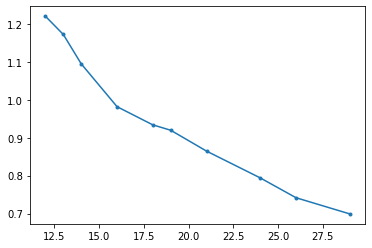

In [82]:
plt.plot(Kvec[0:10],KLsampling[0,0:10],'.-')

In [99]:
KLmx = np.zeros(ZG.N)
KLdist = np.zeros(ZG.N)
for i in range(ZG.N): 
    KLmx[i]=np.nanmax(KLdiff[i,:])
    KLdist[i]=np.argmax(KLdiff[i,:])

KLpk = KLmx-KLdiff[:,-1]

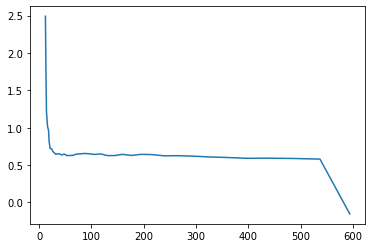

In [112]:
plt.plot(Kvec,KLdiff.mean(axis=0))

Text(0.5, 1.0, 'cell: 2811 dist: 12 info: 2.54 pk: 2.70')

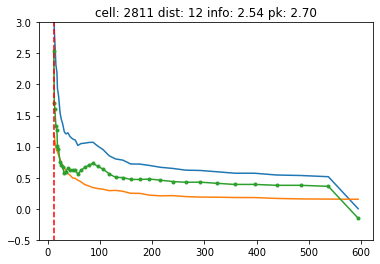

In [100]:
ix = np.random.choice(np.random.randint(KLdiff.shape[0]))
kldist = Kvec[KLdist[ix].astype(np.int64)]
plt.plot(Kvec,KL2g[ix,:])
plt.plot(Kvec,KLsampling[ix,:])
plt.plot(Kvec,KLdiff[ix,:],'.-')
plt.plot([kldist, kldist],[-2, 6],'--r')
plt.ylim(-0.5,3)
plt.title(f"cell: {ix} dist: {kldist:.0f} info: {KLmx[ix]:.2f} pk: {KLpk[ix]:.2f}")

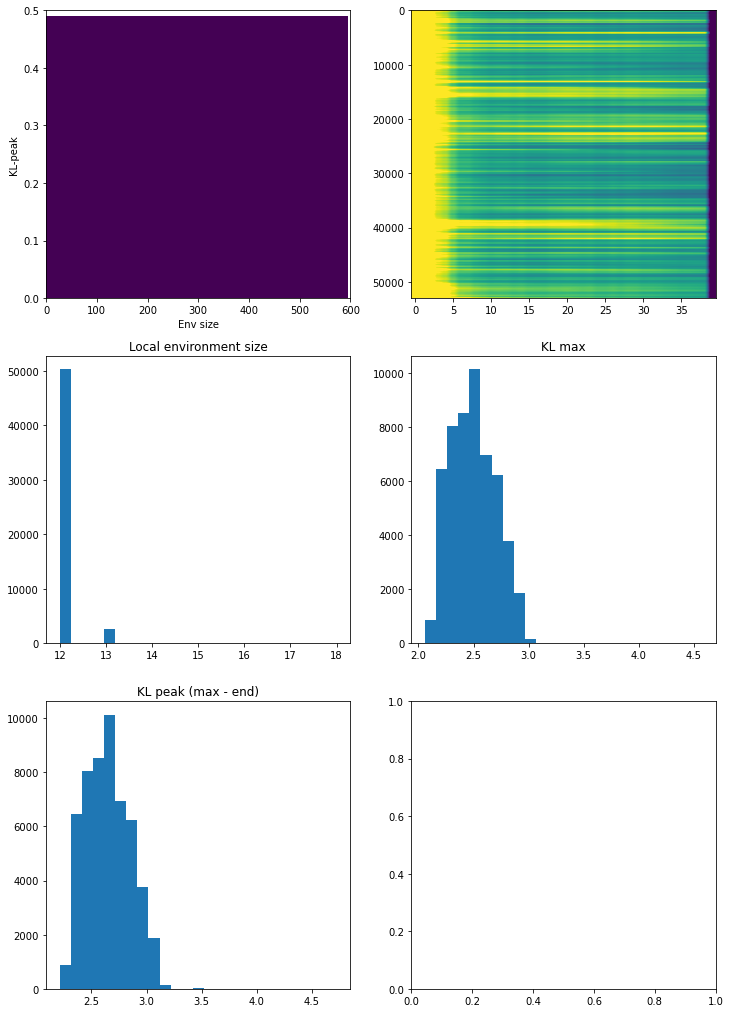

In [101]:
fig,ax = plt.subplots(3,2,figsize=(12,18))

ix=KLpk>1
KLdist2=Kvec[KLdist.astype(np.int64)]
ax[0,0].hist2d(KLdist2,KLpk,bins=(np.arange(0, ZG.MaxEnvSize, 5), np.arange(0, 0.5, 0.01)))
ax[0,0].set(xlim=(0, ZG.MaxEnvSize), ylim=(0, 0.5))
ax[0,0].set_xlabel('Env size')
ax[0,0].set_ylabel('KL-peak')

ax[1,0].hist(KLdist2,bins=25)
ax[1,0].set_title("Local environment size")

ax[1,1].hist(KLmx,bins=25)
ax[1,1].set_title("KL max")

ax[2,0].hist(KLpk,bins=25)
ax[2,0].set_title("KL peak (max - end)")

ordr = np.argsort(KLdist)

ax[0,1].imshow(KLdiff[ordr,:],aspect='auto')
im=ax[0,1].get_images()
im[0].set_clim(vmin=0, vmax=1)




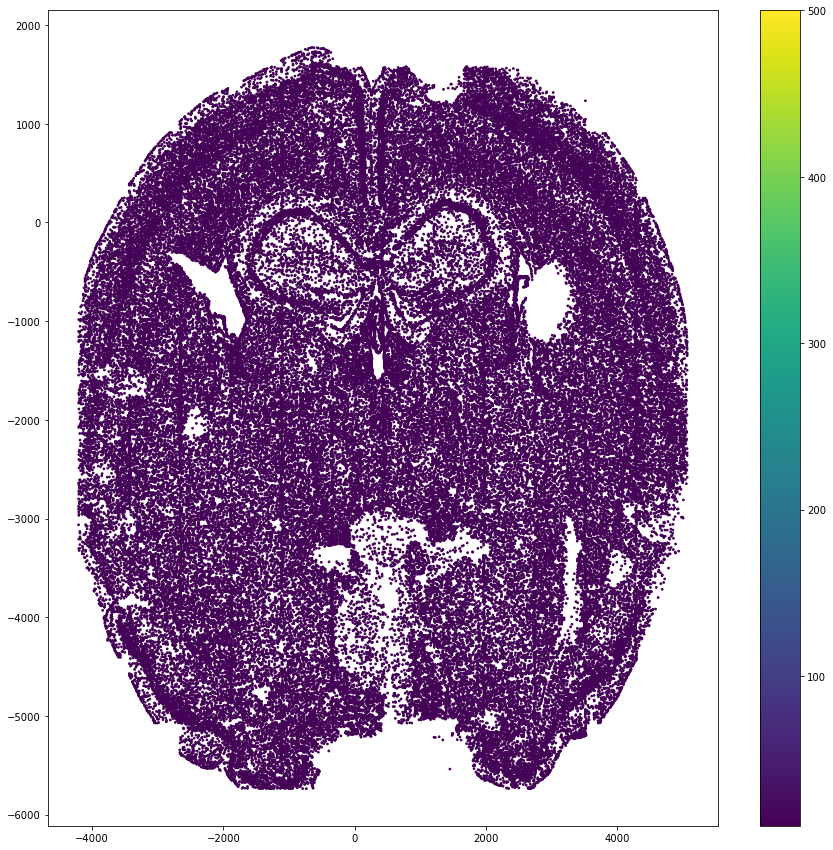

In [58]:
plt.figure(figsize=(15, 15))
kl=KLdist[ZG.UpstreamMap]
kl=Kvec[kl.astype(np.int64)]
plt.scatter(x=TG.X,y=TG.Y,c=kl,s=3,vmin=10,vmax=500)
plt.colorbar()

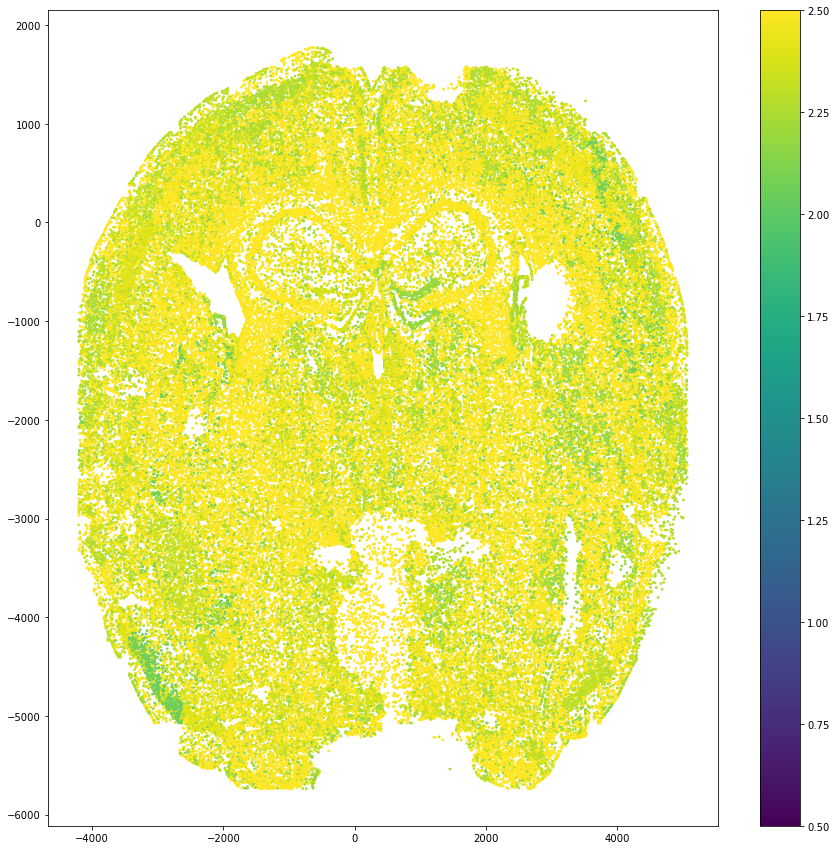

In [59]:
plt.figure(figsize=(15, 15))
kl=KLmx[ZG.UpstreamMap]
plt.scatter(x=TG.X,y=TG.Y,c=kl,s=3,vmin=0.5,vmax=2.5)
plt.colorbar()

In [38]:
def extractEnvironments2(self):
    unqlbl = np.unique(self.Type)
    (distances,indices) = self.SpatialNeighbors
    Env = np.zeros((self.N,len(unqlbl)))
    for i in range(self.N):
        Env[i,:]=CountValues(self.Type[indices[i,0:self.EnvSize[i]]],unqlbl)
    
    # get treemat
    # treemat = self.TX.TreeAsMat() 
    # Env = np.matmul(Env,treemat.T)
    
    return(Env)

In [102]:
Env = ZG.extractEnvironments()
Env.shape

(52991, 200)

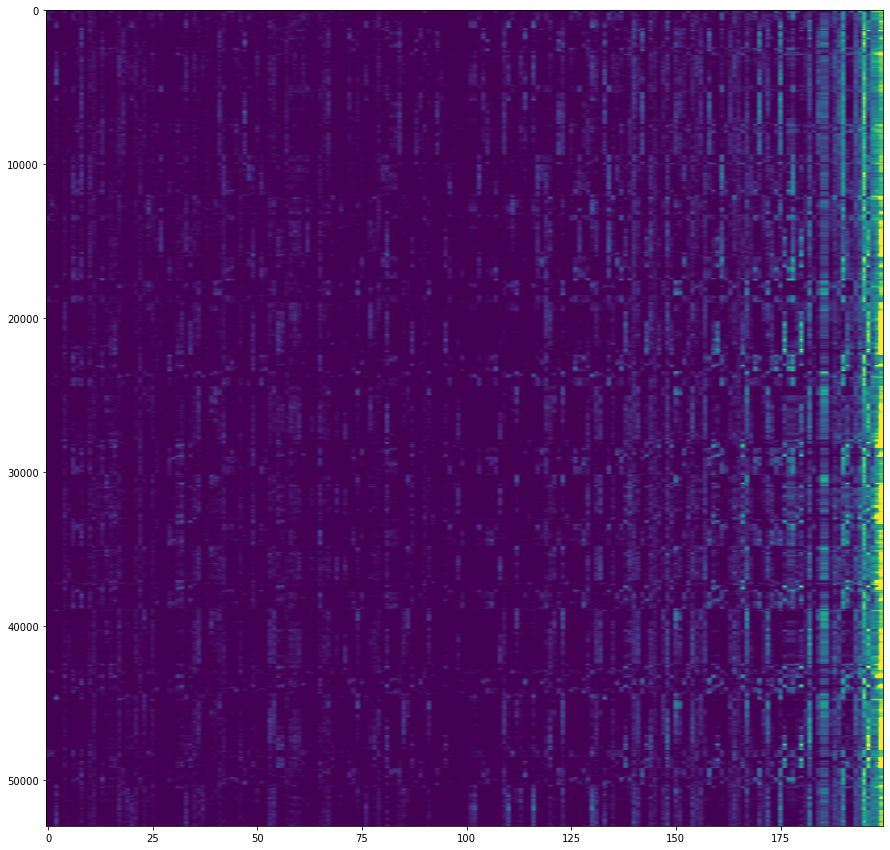

In [103]:
plt.figure(figsize=(15, 15))
plt.imshow(Env,aspect='auto')
im=plt.gca().get_images()
im[0].set_clim(vmin=0, vmax=0.1)



In [104]:
envtypes = ZG.TX.RecursiveLeidenWithTissueGraphCondEntropy(Env,ZG,metric = 'cosine',single_level=True)

Build similarity graph 
calculation took: 23.02
Calling initial optimization
 
 Func-count     x          f(x)          Procedure
    1        11.5208     -3.37744        initial
    2        18.5792     -3.35319        golden
    3        7.15843     -3.32055        golden
    4        13.8595     -3.45307        parabolic
    5        14.8234     -3.44701        parabolic
    6        14.0728     -3.41809        parabolic
    7        12.9662     -3.42906        golden
    8        13.5183     -3.45069        golden
    9        14.0324     -3.41195        parabolic
   10        13.7292     -3.41854        golden
   11        13.9255     -3.40945        golden
   12        13.8097       -3.423        golden
   13        13.8847     -3.42938        golden
   14        13.8405     -3.37885        golden
   15        13.8692     -3.42643        golden
   16        13.8523     -3.45657        golden
   17        13.8478      -3.3626        golden
   18        13.8556     -3.39651        

In [105]:
EG = ZG.ContractGraph(envtypes)



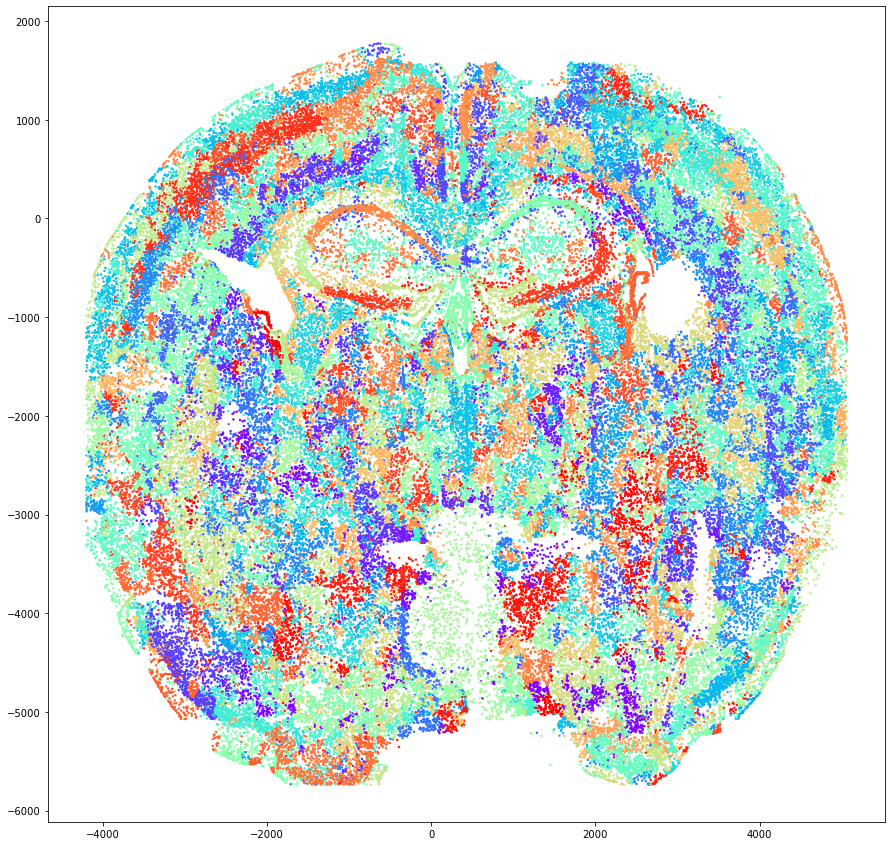

In [106]:
import matplotlib.cm as cm

myenvtype = EG.Type.astype(np.int64)
myenvtype = myenvtype[EG.UpstreamMap[ZG.UpstreamMap]]

unqenv = np.unique(myenvtype)
colors = cm.rainbow(np.linspace(0, 1, len(unqenv)))
colors = colors[np.random.permutation(colors.shape[0]),:]
envcolors = colors[myenvtype,:]
plt.figure(figsize=(15, 15))

plt.scatter(x=TG.X,y=TG.Y,s=2,c=envcolors)
plt.show()

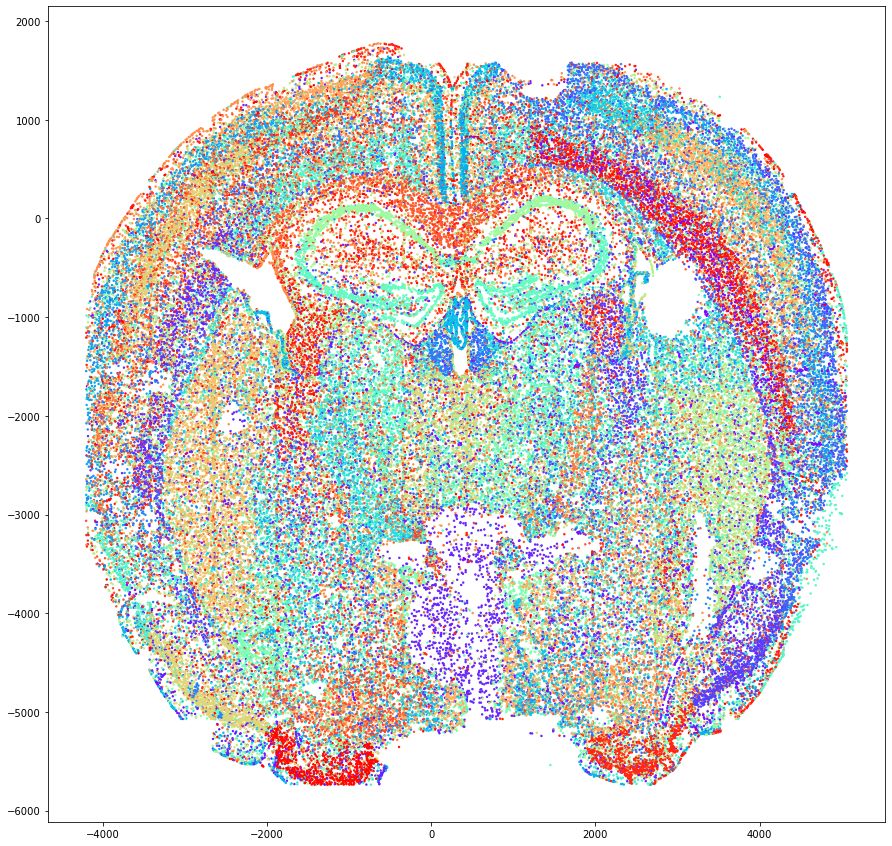

In [107]:
myenvtype = TG.Type.astype(np.int64)

unqenv = np.unique(myenvtype)
colors = cm.rainbow(np.linspace(0, 1, len(unqenv)))
colors = colors[np.random.permutation(colors.shape[0]),:]
envcolors = colors[myenvtype,:]
plt.figure(figsize=(15, 15))

plt.scatter(x=TG.X,y=TG.Y,s=2,c=envcolors)
plt.show()

In [108]:
agraph = buildgraph(Env,metric='cosine')

0.100
0.140
0.196
0.274
0.383
0.536
0.750
1.049
1.468
2.054
2.873
4.019
5.623
7.867
11.007
15.399
21.544
30.142
42.170
58.997
82.540
115.478
161.560
226.030
316.228


Text(0, 0.5, 'Cond Entropy')

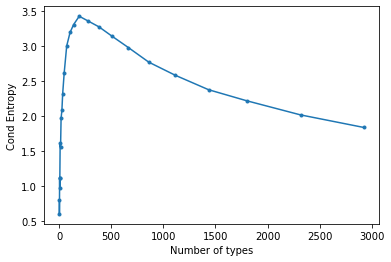

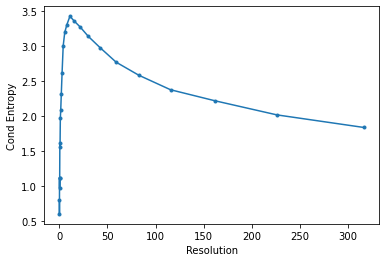

In [109]:
Rvec = np.logspace(-1,2.5,25)
ntypes = list()
entlist = list()

for res in Rvec:
    print(f"{res:.3f}")
    envtype3 = agraph.community_leiden(resolution_parameter=res,objective_function='modularity').membership
    envtype3 = np.array(envtype3,dtype=np.int64)
    entlist.append(ZG.ContractGraph(envtype3).CondEntropy())
    ntypes.append(max(envtype3))

plt.plot(ntypes,entlist,'.-')
plt.xlabel("Number of types")
plt.ylabel("Cond Entropy")
plt.figure()
plt.plot(Rvec,entlist,'.-')
plt.xlabel("Resolution")
plt.ylabel("Cond Entropy")

In [110]:
envtype3 = agraph.community_leiden(resolution_parameter=Rvec[np.argmax(np.array(entlist))],objective_function='modularity').membership
envtype3 = np.array(envtype3,dtype=np.int64)

In [22]:
Rvec[np.argmax(np.array(entlist))]
max(entlist)
ntypes[np.argmax(np.array(entlist))]

266

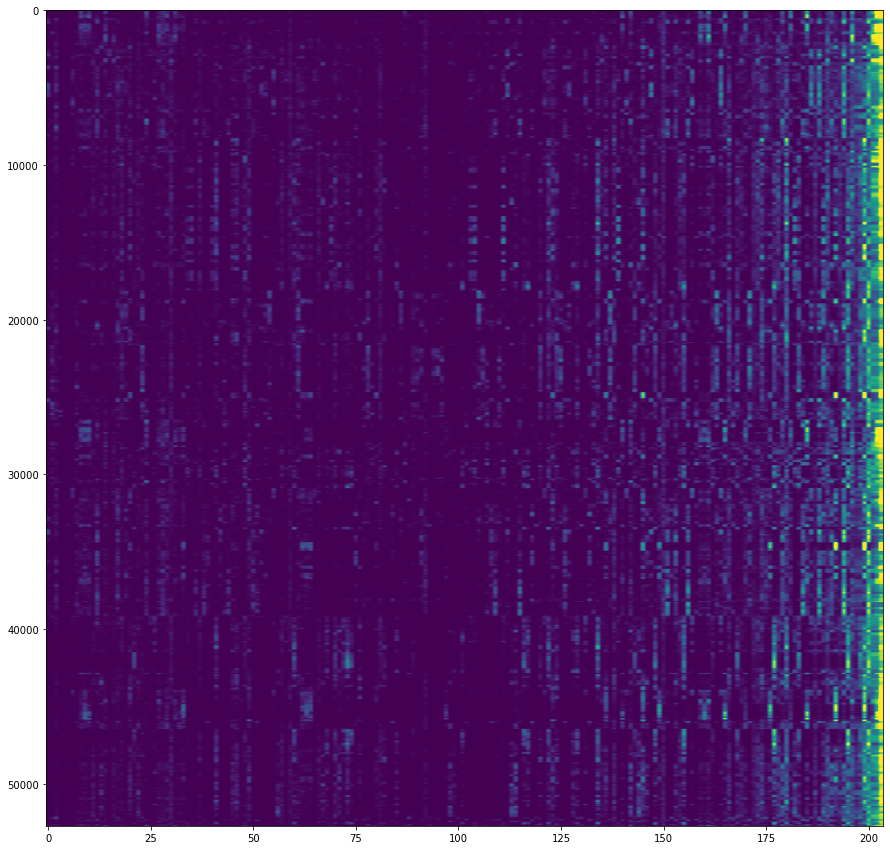

In [23]:
ordr = np.argsort(envtype3)
plt.figure(figsize=(15, 15))
plt.imshow(Env[ordr,:],aspect='auto')
im=plt.gca().get_images()
im[0].set_clim(vmin=0, vmax=0.1)

(array([1568., 1266., 1168., 1178., 1443., 1294., 1080.,  662., 1197.,
        1248., 1014., 1300., 1153., 1678.,  876., 1366., 1152.,  864.,
        1224., 1342., 1543.,  556., 1185., 1036.,  687.,  892.,  587.,
         798., 1073., 1127., 1214., 1128., 1200., 1094.,  936.,  784.,
         933.,  903., 1322.,  856., 1383.,  754., 1113.,  920.,  915.,
         964., 1054.,  697.,  627.,  367.]),
 array([  0.  ,   5.44,  10.88,  16.32,  21.76,  27.2 ,  32.64,  38.08,
         43.52,  48.96,  54.4 ,  59.84,  65.28,  70.72,  76.16,  81.6 ,
         87.04,  92.48,  97.92, 103.36, 108.8 , 114.24, 119.68, 125.12,
        130.56, 136.  , 141.44, 146.88, 152.32, 157.76, 163.2 , 168.64,
        174.08, 179.52, 184.96, 190.4 , 195.84, 201.28, 206.72, 212.16,
        217.6 , 223.04, 228.48, 233.92, 239.36, 244.8 , 250.24, 255.68,
        261.12, 266.56, 272.  ]),
 <BarContainer object of 50 artists>)

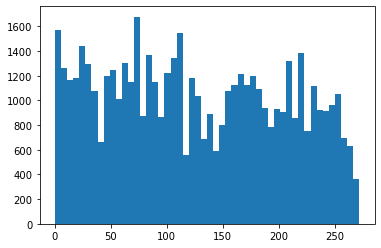

In [24]:
Counter(envtype3)

plt.hist(envtype3,bins=50)

In [25]:
print(mean(EG.NodeSize>10))
print(sum(EG.NodeSize[EG.NodeSize>10])/ZG.N)

0.08876629889669058
0.6988865916807344


(array([8.759e+03, 4.250e+02, 1.840e+02, 1.170e+02, 8.900e+01, 6.100e+01,
        4.900e+01, 3.900e+01, 4.100e+01, 2.700e+01, 1.800e+01, 2.400e+01,
        1.600e+01, 1.100e+01, 1.200e+01, 9.000e+00, 1.000e+01, 6.000e+00,
        9.000e+00, 6.000e+00, 1.000e+01, 5.000e+00, 5.000e+00, 2.000e+00,
        2.000e+00, 3.000e+00, 2.000e+00, 7.000e+00, 2.000e+00, 4.000e+00,
        1.000e+00, 3.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([  1.  ,   6.72,  12.44,  18.16,  23.88,  29.6 ,  35.32,  41.04,
         46.76,  52.48,  58.2 ,  63.92,  69.64,  75.36,  81.08,  86.8 ,
         92.52,  98.24, 103.96, 109.68, 115.4 , 121.12, 126.84, 132.56,
        138.28, 144.  , 149.72, 155.44, 161.16, 166.88, 172.6 , 178.32,
        184.04, 189.76, 195.48, 201.2 , 206.92, 212.64, 218.36, 224.08,
        229.8 , 

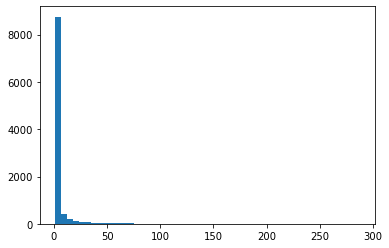

In [26]:
plt.hist(EG.NodeSize,bins=50)

In [27]:
from scipy.spatial.distance import jensenshannon